## Task 5: Route Analysis

In [6]:
import osmnx as ox
import pandas as pd
import collections
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### (1) to return 10 road segments that are traversed the most often as indicated by the trajectory data;

In [11]:
def load_and_preprocess_data(match_path):
    df = pd.read_csv(match_path, engine='python')
    df = df.loc[df['mgeom'].str.contains("LINESTRING") & (df['mgeom'] != 'LINESTRING()')]
    df.dropna(inplace=True)
    return df

def extract_road_segments(df):
    road_segments = df['cpath'].tolist()
    road_segments = ",".join(road_segments).split(",")

    # Clean and convert to integers
    road_segments = [int(item.strip().replace('[', '').replace(']', '')) for item in road_segments if item.strip()]
    return road_segments

def get_most_common_segments(road_segments, top_n=10):
    counter = collections.Counter(road_segments)
    most_common = counter.most_common(top_n)

    print('10 FIDs road segments that are traversed the most often:')
    for idx, (key, freq) in enumerate(most_common):
        print(f"{idx + 1}. Road ID: {key}, Use Count: {freq}")

    return [int(i[0]) for i in most_common]



### visualize the road segments returned in (1) 

In [12]:
def visualize_segments_on_map(edge_path, most_common_segments):
    mgeoms = gpd.read_file(edge_path, index_col='fid')['geometry']
    mgeoms = mgeoms[mgeoms.index.isin(most_common_segments)]
    
    coordinates = [np.array([list(i) for i in geom.coords]) for geom in mgeoms]

    road_network = ox.graph_from_place('Porto Portugal', network_type='drive')
    fig, ax = ox.plot_graph(road_network, node_size=2, show=False, close=False, figsize=(48, 48), bgcolor='#FFFFFF', edge_linewidth=2)

    color_list = ['#8000ff', '#00b5eb', '#80ffb4', '#ffb360', '#ff0000', '#FFFF00', '#FF00FF', '#00FFFF', '#808080', '#008000']
    for idx, c in enumerate(color_list[:len(coordinates)]):  # Using slicing to ensure we only use as many colors as we have coordinates for
        plt.plot(*coordinates[idx].T, color=c, linewidth=8)

    plt.show()

10 FIDs road segments that are traversed the most often:
1. Road ID: 100535, Use Count: 171
2. Road ID: 4239, Use Count: 164
3. Road ID: 42, Use Count: 147
4. Road ID: 1461, Use Count: 141
5. Road ID: 158673, Use Count: 135
6. Road ID: 1559, Use Count: 134
7. Road ID: 1547, Use Count: 133
8. Road ID: 47, Use Count: 131
9. Road ID: 188463, Use Count: 124
10. Road ID: 50, Use Count: 121


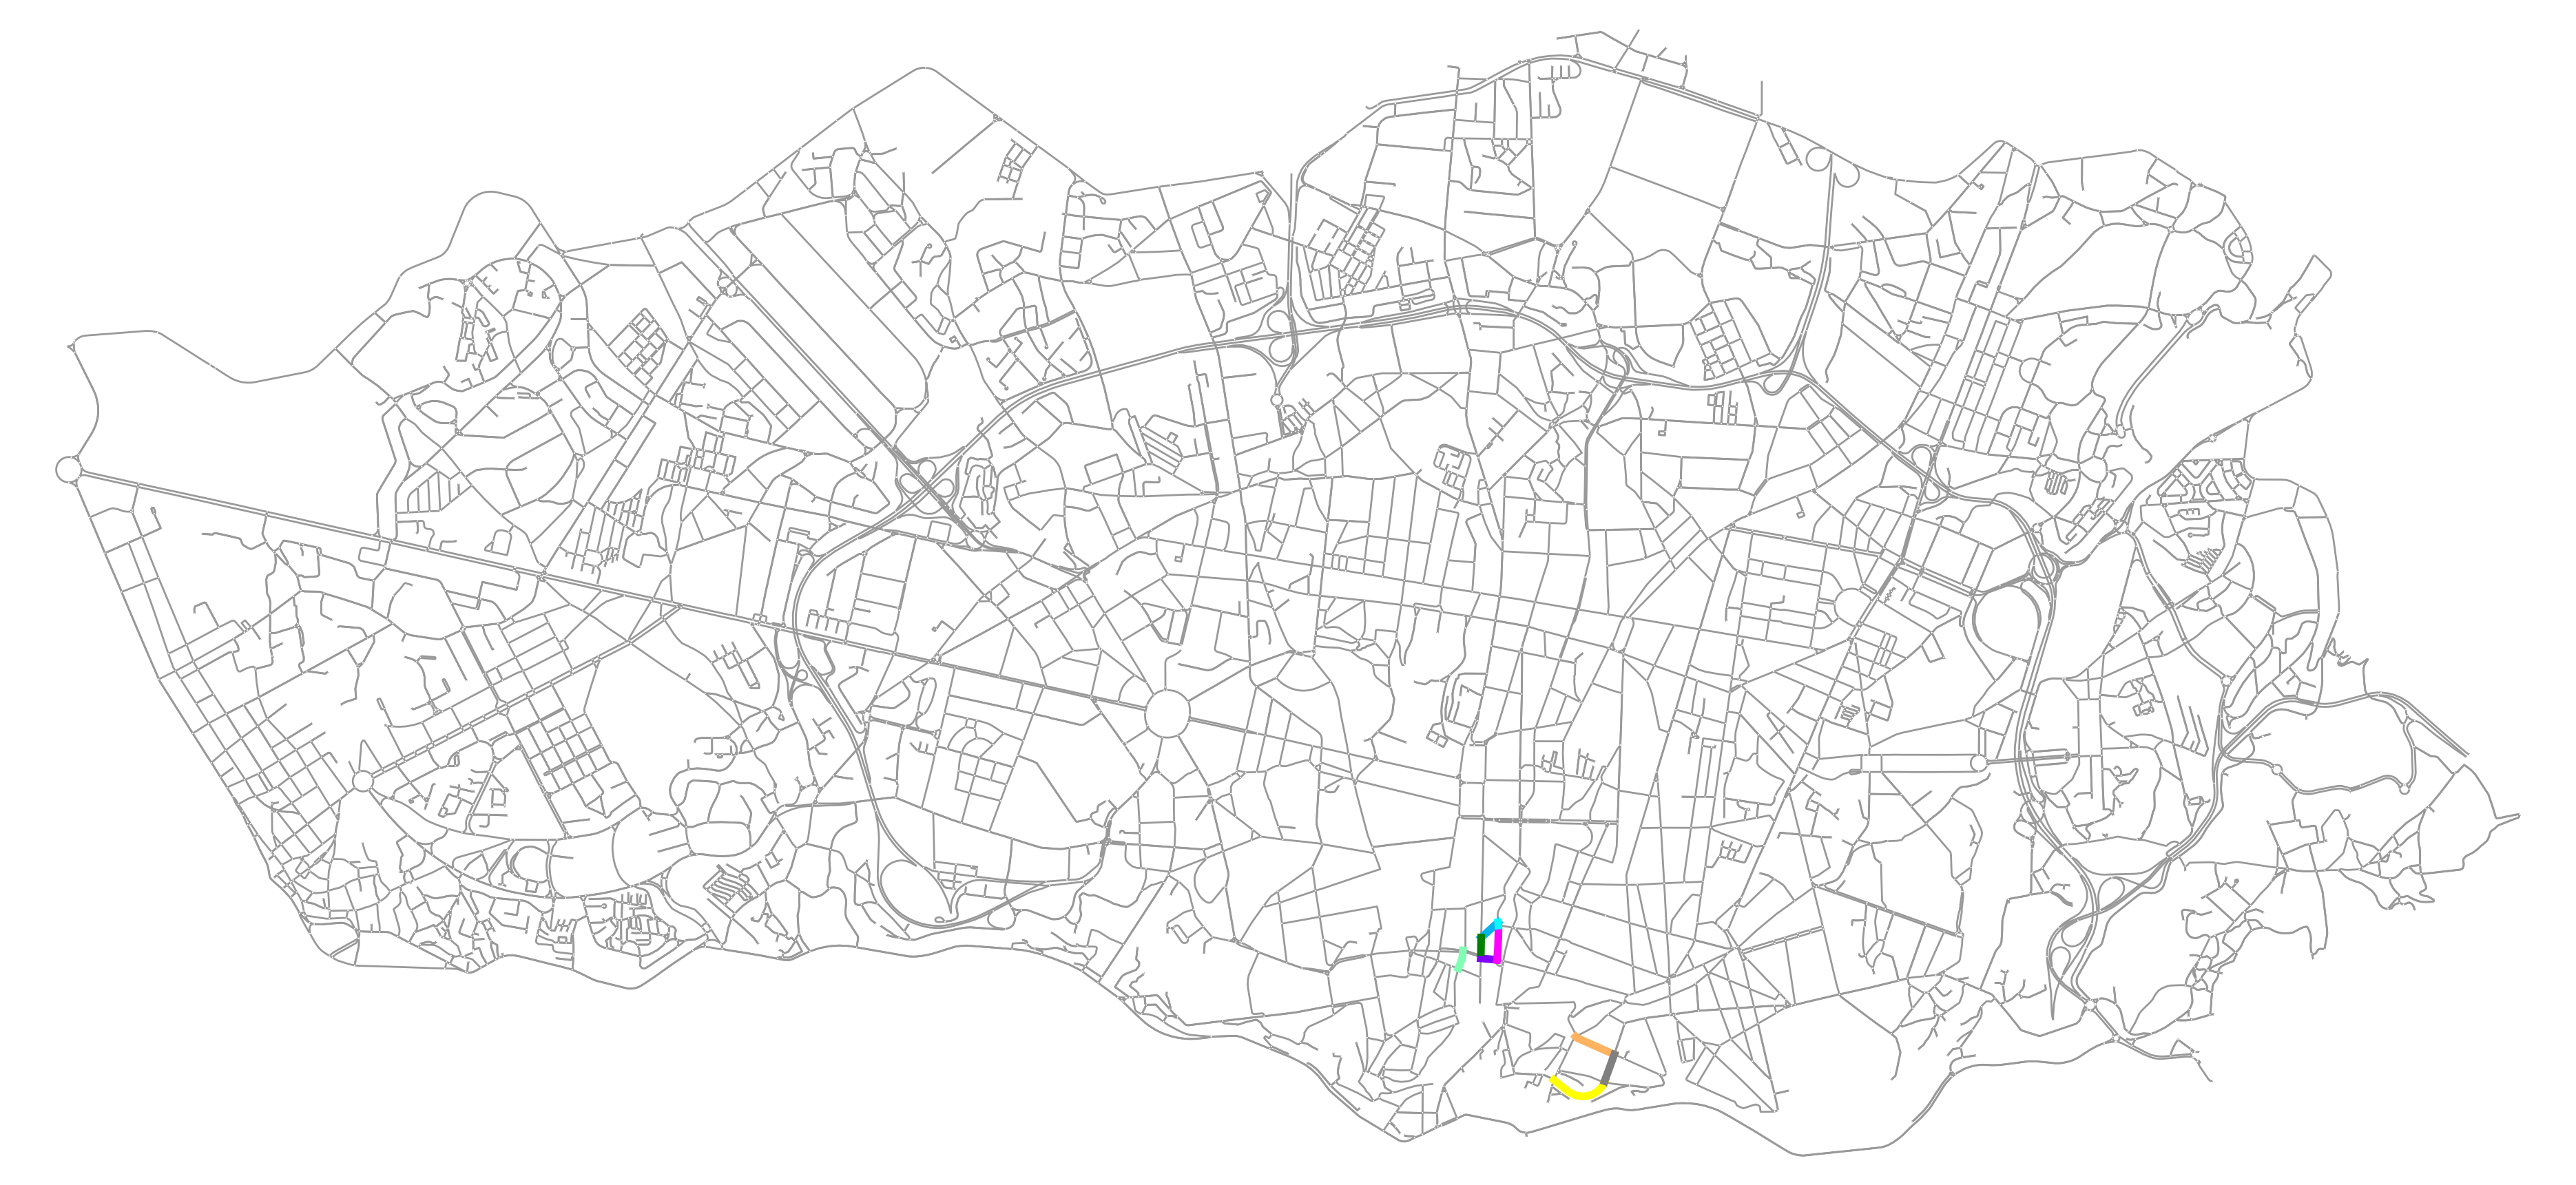

In [14]:
match_path = 'data/matched_routines.csv'
edge_path = 'data/porto/edges.shp'

df = load_and_preprocess_data(match_path)
road_segments = extract_road_segments(df)
most_common_segments = get_most_common_segments(road_segments)
visualize_segments_on_map(edge_path, most_common_segments)

#### Partial Enlargement

10 FIDs road segments that are traversed the most often:
1. Road ID: 100535, Use Count: 171
2. Road ID: 4239, Use Count: 164
3. Road ID: 42, Use Count: 147
4. Road ID: 1461, Use Count: 141
5. Road ID: 158673, Use Count: 135
6. Road ID: 1559, Use Count: 134
7. Road ID: 1547, Use Count: 133
8. Road ID: 47, Use Count: 131
9. Road ID: 188463, Use Count: 124
10. Road ID: 50, Use Count: 121


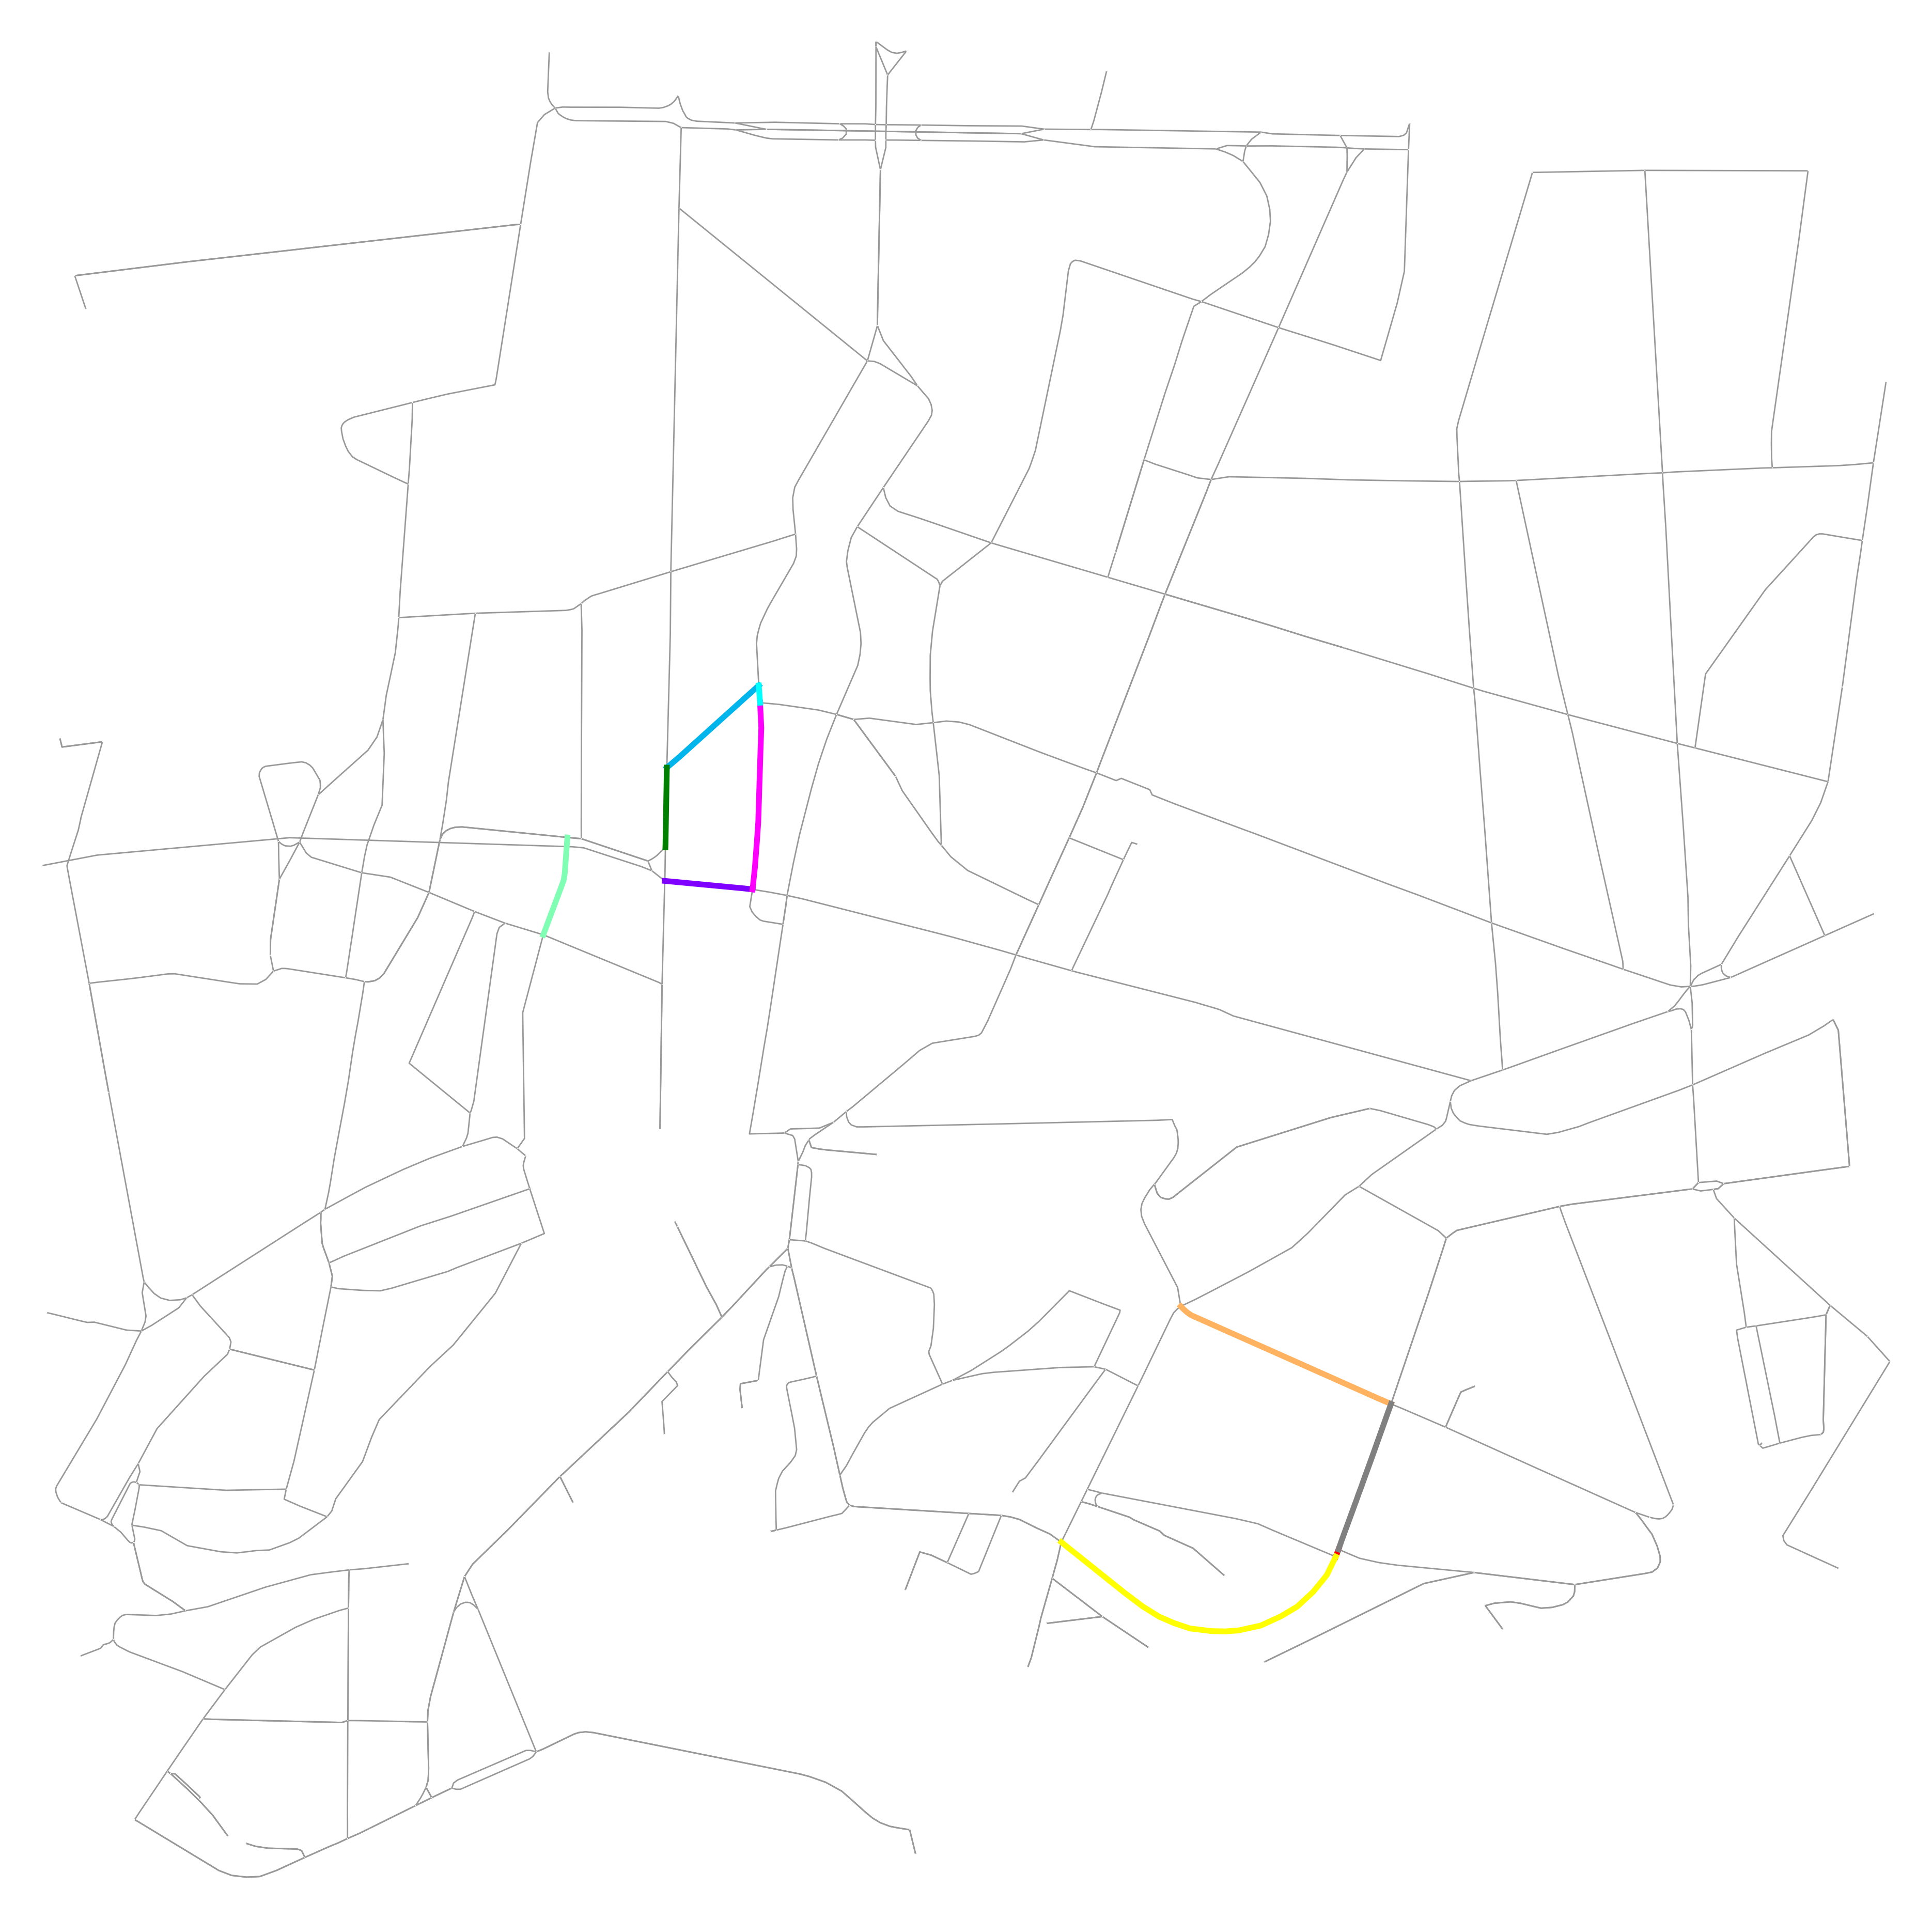

In [15]:
from shapely.geometry import Polygon

# show details

def get_coordinates_bounds(coordinates):
    all_x, all_y = [], []
    for segment in coordinates:
        x, y = segment.T
        all_x.extend(x)
        all_y.extend(y)

    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    
    buffer_distance = 0.005  # 添加一个小的缓冲区来稍微扩大显示的区域
    return x_min - buffer_distance, x_max + buffer_distance, y_min - buffer_distance, y_max + buffer_distance

def visualize_segments_on_map(edge_path, most_common_segments):
    mgeoms = gpd.read_file(edge_path, index_col='fid')['geometry']
    mgeoms = mgeoms[mgeoms.index.isin(most_common_segments)]
    
    coordinates = [np.array([list(i) for i in geom.coords]) for geom in mgeoms]
    
    x_min, x_max, y_min, y_max = get_coordinates_bounds(coordinates)

    # 使用坐标范围创建多边形
    boundary_polygon = Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])
    
    road_network = ox.graph_from_polygon(boundary_polygon, network_type='drive')
    fig, ax = ox.plot_graph(road_network, node_size=2, show=False, close=False, figsize=(48, 48), bgcolor='#FFFFFF', edge_linewidth=2)

    color_list = ['#8000ff', '#00b5eb', '#80ffb4', '#ffb360', '#ff0000', '#FFFF00', '#FF00FF', '#00FFFF', '#808080', '#008000']
    for idx, c in enumerate(color_list[:len(coordinates)]):
        plt.plot(*coordinates[idx].T, color=c, linewidth=8)

    plt.show()

match_path = 'data/matched_routines.csv'
edge_path = 'data/porto/edges.shp'

df = load_and_preprocess_data(match_path)
road_segments = extract_road_segments(df)
most_common_segments = get_most_common_segments(road_segments)

visualize_segments_on_map(edge_path, most_common_segments)

 (2) to return 10 road segments,
whose average travelling time as indicated by the trajectory data
are the largest (those road segments that are traversed by no
trajectories can be ignored);

In [48]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import osmnx as ox
from matplotlib import pyplot as plt
from shapely.geometry import Polygon
import json

FOLDER_PATH = 'data'
FMM_FILENAME = 'matched_routines.csv'
EDGE_SHP_PATH = "porto/edges.shp"
BOUNDS = (-8.70, -8.57, 41.19, 41.13)

def map_fid_to_avg_travel_time(results_df, edges_df):
    """Map each fid to an average time for each trip."""
    cols = ['trip_id', 'name', 'length', 'u', 'v', 'osmid', 'time_taken']
    road_segment_time = []
    for idx, row in results_df.iterrows():
        traject_path = json.loads(row['match_path'])
        traject_path_df = pd.DataFrame({'fid': traject_path})
        traject_path_df = traject_path_df.merge(edges_df, on='fid')
        traject_path_df['time_taken'] = row['time_taken'] * (traject_path_df['length'] / traject_path_df['length'].sum())
        traject_path_df['trip_id'] = idx
        road_segment_time.append(traject_path_df[cols])
    return pd.concat(road_segment_time, ignore_index=True)

def main():
    # Load data
    results_df = pd.read_csv(os.path.join(FOLDER_PATH, FMM_FILENAME))
    edges_df = gpd.read_file(os.path.join(FOLDER_PATH, EDGE_SHP_PATH))
    edges_df = edges_df[['name', 'u', 'v', 'length', 'osmid', 'fid', 'geometry']]
    
    # Process data
    road_segment_time = map_fid_to_avg_travel_time(results_df, edges_df)
    avg_road_segment_time = road_segment_time.groupby(['name', 'length', 'osmid', 'u', 'v'], as_index=False)\
        .agg(avg_time=('time_taken', 'mean'))
    avg_road_segment_time['avg_time_per_unit_length'] = avg_road_segment_time['avg_time'] / avg_road_segment_time['length']
    total_avg_time = avg_road_segment_time.groupby(['name', 'osmid'], as_index=False)\
        .agg({'avg_time_per_unit_length': 'mean', 'length': 'sum'})
    total_avg_time['avg_time'] = total_avg_time['avg_time_per_unit_length'] * total_avg_time['length']
    top_5_segments = total_avg_time.nlargest(5, 'avg_time')
    
    # Visualize results
    boundary_polygon = Polygon([(x[0], x[1]) for x in zip(BOUNDS[::2], BOUNDS[1::2])])
    G = ox.graph_from_polygon(boundary_polygon, network_type='drive')
    fig, ax = ox.plot_graph(G, figsize=(30, 20), show=False, node_size=0, bgcolor='w', edge_color="k", edge_linewidth=0.5)
    for _, row in top_5_segments.merge(edges_df, on='osmid').iterrows():
        geom = list(row['geometry'].coords)
        plt.plot(*zip(*geom), label=f"{row['name']} (Time Taken: {row['avg_time']:.2f}mins)", linewidth=3)
    plt.legend(fontsize=25)
    plt.savefig(os.path.join(FOLDER_PATH, 'Top 5 Road Segments with Longest Average Travelling Time'))
    plt.show()

if __name__ == "__main__":
    main()


KeyError: 'match_path'

In [ ]:
edge_dataframe = gp.GeoDataFrame.from_file('data/porto/edges.shp')
nodes_dataframe = gp.GeoDataFrame.from_file('data/porto/nodes.shp')